6 September 2019: This notebook serves to investigate the influence of different timesteps, $\Delta t$, in the advection step. The default step used in most particle runs so far is 5 seconds. One run, ``control_y300_P3590x590_S2000-1-1_D90_DT60_ODT12_LAT60.5-89.5_LON-179.5-179.5`` has a time step of 60 seconds. The particle set of this run can be compared to ``pset_control_y300_P3590x590_S2000-1-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5``, since all settings, except for the _runtime_ and $\Delta t$ are equal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
pset_path = '/data/oceanparcels/output_data/data_Daan/'

In [3]:
ds_dt60 = xr.open_dataset(pset_path+'pset_control_y300_P3590x590_S2000-1-1_D90_DT60_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')
ds_dt5 = xr.open_dataset(pset_path+'pset_control_y300_P3590x590_S2000-1-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')

In [4]:
print('Technical data')
print('--------------')
print('-----dt60-----')
print(ds_dt60)
print('-----dt5------')
print(ds_dt5)

Technical data
--------------
-----dt60-----
<xarray.Dataset>
Dimensions:     (obs: 181, traj: 2118100)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) int32 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.0.0b3.dev93+g5cdb2e5
    parcels_mesh:           spherical
-----dt5------
<xarray.Dataset>
Dimensions:     (obs: 61, traj: 2118100)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) int32 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory

# Indices

``ds_dt60`` covers a time span of 90 days:

In [5]:
ds_dt60.time[0,-1].values

numpy.datetime64('2000-03-31T00:00:00.000000000')

``ds_dt5`` only covers a time span of 30 days:

In [6]:
ds_dt5.time[0,-1].values

numpy.datetime64('2000-01-31T00:00:00.000000000')

This means we have to be careful with choosing the correct value in ``ds_dt60`` so we match up our data with ``ds_dt5``. The correct index is ``60``:

In [7]:
ds_dt60.time[0,60].values

numpy.datetime64('2000-01-31T00:00:00.000000000')

# Position comparison
Since both simulations stem from the same original particle grid, we can readily compare the final positions of the particles. This can for example be done for particles released along a certain longitude band/meridian. We investigate $0^\circ$, since the prime meridian coincides with the Fram Straight, and should thus consist of particles in water (as opposed to the trivial case of particles on land).

Note: these simulations were carried out with initial particle grids where particles on land were not yet removed.

## Trajectory index
The initial lat-lon positions are simply stored in sequential order, first going from 179.5W to 179.5E, then going from 60.5N to 89.5N. Therefore, we have to be mindful that when we want to select a meridian, we have to select each 3590th element in our array. ``1795::3590`` selects the prime meridian:

In [8]:
ds_dt60.lon[1795::3590,0]

<xarray.DataArray 'lon' (traj: 590)>
array([0.050014, 0.050014, 0.050014, ..., 0.050014, 0.050014, 0.050014],
      dtype=float32)
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

In [9]:
ds_dt5.lon[1795::3590,0]

<xarray.DataArray 'lon' (traj: 590)>
array([0.050014, 0.050014, 0.050014, ..., 0.050014, 0.050014, 0.050014],
      dtype=float32)
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

In [10]:
ds_dt60.lat[1795::3590,0]

<xarray.DataArray 'lat' (traj: 590)>
array([60.5     , 60.549236, 60.598473, ..., 89.40153 , 89.45077 , 89.5     ],
      dtype=float32)
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  latitude
    units:          degrees_north
    axis:           Y

In [11]:
ds_dt5.lat[1795::3590,0]

<xarray.DataArray 'lat' (traj: 590)>
array([60.5     , 60.549236, 60.598473, ..., 89.40153 , 89.45077 , 89.5     ],
      dtype=float32)
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  latitude
    units:          degrees_north
    axis:           Y

## Distances shifted
We can now simply take the euclidian difference between each final location. Note that we use index ``60`` for ``ds_dt60``. First we have to define a function to compute distances using the Haversine formula<sup>[1]</sup>.

[1]: https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97

In [76]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

The rest is straightforward:

In [87]:
merid_dist_diff = haversine(ds_dt5.lon[1795::3590,-1],\
                            ds_dt5.lat[1795::3590,-1],\
                            ds_dt60.lon[1795::3590,60],\
                            ds_dt60.lat[1795::3590,60])

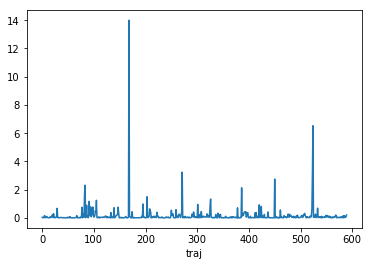

In [88]:
merid_dist_diff.plot()

In [92]:
merid_dist_diff.mean()

<xarray.DataArray ()>
array(0.162516, dtype=float32)

In [91]:
merid_dist_diff.mean()/30

<xarray.DataArray ()>
array(0.005417)

The mean difference is distance is rather small. Here we see that the largest differences only span around 14 kilometers, but the average is only 162 meters (over the coure of 30 days), meaning a drift of 5 meters a day.

# Spatial plot

In [16]:
lon_5 = ds_dt5.lon[1795::3590,-1]
lat_5 = ds_dt5.lat[1795::3590,-1]
lon_60 = ds_dt60.lon[1795::3590,60]
lat_60 = ds_dt60.lat[1795::3590,60]

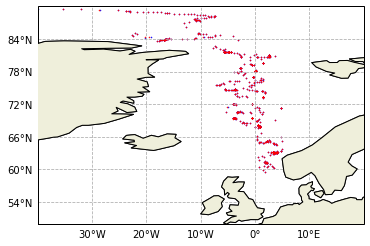

In [72]:
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig     = plt.figure()
ax      = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-40,20,50,90), crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', draw_labels = True)
gl.xlabels_top   = False
gl.ylabels_right = False
gl.xformatter    = LONGITUDE_FORMATTER
gl.yformatter    = LATITUDE_FORMATTER
ax.scatter(lon_5, lat_5, s=0.3, c='blue', transform=ccrs.PlateCarree())
ax.scatter(lon_60, lat_60, s=0.3, c='red', transform=ccrs.PlateCarree())
plt.show()

Here the spread between particle locations does not seem that large. Let's look at individual distances between trajectories:

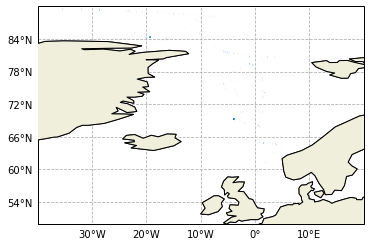

In [73]:
import cartopy as cart
import cartopy.crs as ccrs
from matplotlib import collections  as mc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig     = plt.figure()
ax      = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-40,20,50,90), crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', draw_labels = True)
gl.xlabels_top   = False
gl.ylabels_right = False
gl.xformatter    = LONGITUDE_FORMATTER
gl.yformatter    = LATITUDE_FORMATTER

init_coords = np.dstack((lon_5, lat_5))
final_coords = np.dstack((lon_60, lat_60))
# Lines drawn from locations from dt5-run to locations from dt60-run.
lines = np.dstack((init_coords, final_coords)).flatten().reshape(len(lon_5),2,2)
lc = mc.LineCollection(lines, linewidths=2)
ax.add_collection(lc)
plt.show()

Above are lines drawn from locations from dt5-run to locations from dt60-run. These lines are nearly invisible, indicating that the shifted distances are very small.

# Full comparison

Let's compare positions for the full data set:

In [100]:
import seaborn as sns

In [93]:
full_dist_diff = haversine(ds_dt5.lon[:,-1],\
                            ds_dt5.lat[:,-1],\
                            ds_dt60.lon[:,60],\
                            ds_dt60.lat[:,60])

In [106]:
print("Standard deviation:", full_dist_diff.std())
print("Mean:", full_dist_diff.mean())
print("Max:", full_dist_diff.max())

Standard deviation: <xarray.DataArray ()>
array(4.523793, dtype=float32)
Mean: <xarray.DataArray ()>
array(0.710348, dtype=float32)
Max: <xarray.DataArray ()>
array(577.5872, dtype=float32)


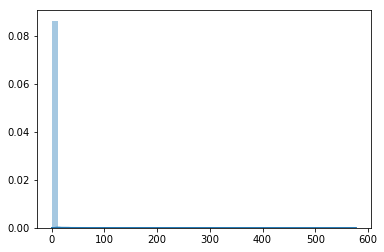

In [104]:
sns.distplot(full_dist_diff[~np.isnan(full_dist_diff)])